In [8]:
# https://stackoverflow.com/questions/57422899/modulenotfounderror-no-module-named-jupyter-notebooks
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import warnings
from datetime import datetime

import openpolicedata as opd

In [2]:
us_state_abbrev = {
    'AL' : 'Alabama', 
    'AK' : 'Alaska',
    'AS' : 'American Samoa',
    'AZ' : 'Arizona',
    'AR' : 'Arkansas',
    'CA' : 'California',
    'CO' : 'Colorado',
    'CT' : 'Connecticut',
    'DE' : 'Delaware',
    'DC' : 'District of Columbia',
    'FL' : 'Florida',
    'GA' : 'Georgia',
    'GU' : 'Guam',
    'HI' : 'Hawaii',
    'ID' : 'Idaho',
    'IL' : 'Illinois',
    'IN' : 'Indiana',
    'IA' : 'Iowa',
    'KS' : 'Kansas',
    'KY' : 'Kentucky',
    'LA' : 'Louisiana',
    'ME' : 'Maine',
    'MD' : 'Maryland',
    'MA' : 'Massachusetts',
    'MI' : 'Michigan',
    'MN' : 'Minnesota',
    'MS' : 'Mississippi',
    'MO' : 'Missouri',
    'MT' : 'Montana',
    'NE' : 'Nebraska',
    'NV' : 'Nevada',
    'NH' : 'New Hampshire',
    'NJ' : 'New Jersey',
    'NM' : 'New Mexico',
    'NY' : 'New York',
    'NC' : 'North Carolina',
    'ND' : 'North Dakota',
    'MP' : 'Northern Mariana Islands',
    'OH' : 'Ohio',
    'OK' : 'Oklahoma',
    'OR' : 'Oregon',
    'PA' : 'Pennsylvania',
    'PR' : 'Puerto Rico',
    'RI' : 'Rhode Island',
    'SC' : 'South Carolina',
    'SD' : 'South Dakota',
    'TN' : 'Tennessee',
    'TX' : 'Texas',
    'UT' : 'Utah',
    'VT' : 'Vermont',
    'VI' : 'Virgin Islands',
    'VA' : 'Virginia',
    'WA' : 'Washington',
    'WV' : 'West Virginia',
    'WI' : 'Wisconsin',
    'WY' : 'Wyoming'
}

def abbrev2state(state):
    if len(state) == 2: # Otherwise, assume state name was passed in
        state = us_state_abbrev[state.upper()]

    return state

def state2abbrev(state):
    if len(state) != 2:
        state = next(key for key, value in us_state_abbrev.items() if value == state)

    return state

state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

In [3]:
datasets = opd.datasets.query()
df = datasets.drop_duplicates(subset=["State","SourceName","Agency"])

num_state = (df["Agency"]=="MULTI").sum()
print(f"Number of state datasets is {num_state}")
print(f"Number of PD datasets is {len(df) - num_state}")

df_stanford = df[df.URL.str.contains("stanford.edu")]
num_state_stanford = (df_stanford["Agency"]=="MULTI").sum()
print(f"Number of state datasets in Stanford data is {num_state_stanford}")
print(f"Number of PD datasets in Stanford data is {len(df_stanford)-num_state_stanford}")

Number of state datasets is 9
Number of PD datasets is 127
Number of state datasets in Stanford data is 5
Number of PD datasets in Stanford data is 73


In [4]:
datasets = opd.datasets.query()
df = datasets.drop_duplicates(subset=["State","SourceName","Agency","TableType"])
df_stanford = df[df.URL.str.contains("stanford.edu")]

df_stanford["TableType"].value_counts()

TRAFFIC STOPS    55
STOPS            23
Name: TableType, dtype: int64

In [5]:
# Need to download https://www2.census.gov/geo/tiger/TIGER2021/STATE/tl_2021_us_state.zip
state_file = "./tl_2021_us_state.zip!tl_2021_us_state.shp"
state_df = gpd.read_file(state_file)
state_df = state_df.to_crs("EPSG:4326")

In [6]:
# Need to download from https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip
county_file = "./tl_2021_us_county.zip!tl_2021_us_county.shp"
county_df = gpd.read_file(county_file)
county_df = county_df.to_crs("EPSG:4326")

/tmp/ipykernel_93674/749651607.py:4: DeprecationWarning: opd.datasets_query is deprecated and will be removed in a future version. Please opd.datasets.query instead.
  datasets = opd.datasets_query()


Not keeping California
Not keeping Virginia


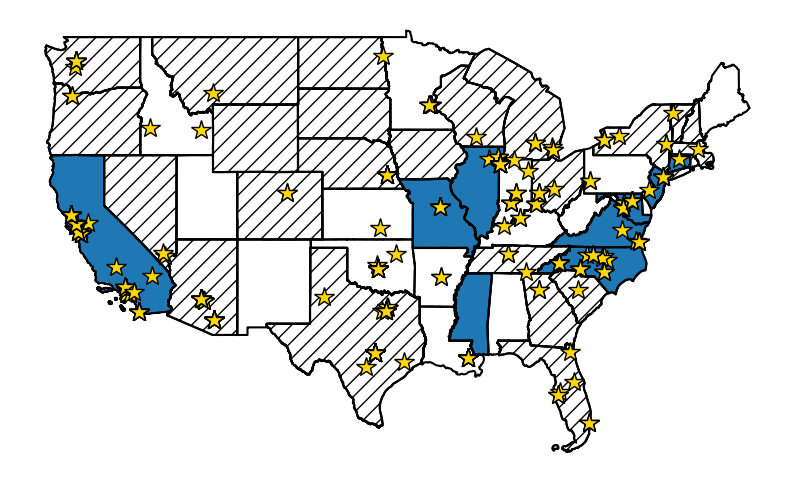

In [9]:
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us48 = state_df
markersize = 15
datasets = opd.datasets_query()
for n in non_continental:
    us48 = us48[us48.STUSPS != n]

fig,ax = plt.subplots(figsize=(10,25))
us48.boundary.plot(ax=ax,edgecolor="black")

for i in range(len(datasets)):
    abbrev = state2abbrev(datasets.iloc[i]["State"])

    if opd.defs.MULTI == datasets.iloc[i]["Agency"]:
        state = us48[us48.STUSPS == abbrev]
        state.plot(ax=ax,edgecolor="black")

for i in range(len(datasets)):
    abbrev = state2abbrev(datasets.iloc[i]["State"])

    if datasets.iloc[i]["Agency"] == "State Patrol" or datasets.iloc[i]["Agency"] == "State Police":
        keep = True
        for j in range(len(datasets)):
            if opd.defs.MULTI == datasets.iloc[j]["Agency"] and \
                datasets.iloc[i]["State"] == datasets.iloc[j]["State"]:
                keep = False
        if keep:
            state = us48[us48.STUSPS == abbrev]
            state.boundary.plot(ax=ax, hatch="//",edgecolor="black")    
        else:
            state_str = "State"
            print(f"Not keeping {datasets.iloc[i][state_str]}")

for i in range(len(datasets)):
    abbrev = state2abbrev(datasets.iloc[i]["State"])

    if opd.defs.MULTI == datasets.iloc[i]["Agency"] or \
        datasets.iloc[i]["Agency"] == "State Patrol" or \
        datasets.iloc[i]["Agency"] == "State Police":
        pass
    elif "County" not in datasets.iloc[i]["SourceName"]:
        city_name = datasets.iloc[i]["SourceName"].replace("Police Department","").strip()
        try:
            city = cx.Place(f"{city_name}, {abbrev}")
            lat = city.latitude
            lon = city.longitude
        except:
            if (city_name == "San Jose"):
                lat = 37.3382082
                lon = -121.8863286
            else:
                print(f"Skipping {city_name}, {abbrev}. Unable to get place")
                continue
        try:
            ax.plot(lon, lat, marker="*", markeredgecolor="k" ,markerfacecolor="gold", markersize=markersize)
        except:
            print(f"Skipping {city_name}, {abbrev}. Unable to plot")
    else:
        county_name = datasets.iloc[i]["SourceName"].replace("Police Department","").strip()
        fips = state_codes[abbrev]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            df = county_df[county_df["STATEFP"]==fips]
            df = df[county_df["NAMELSAD"]==county_name]
            a = df.centroid
        try:
            ax.plot(a.x, a.y, marker="*", markeredgecolor="k" ,markerfacecolor="gold", markersize=markersize)
        except:
            print(f"Skipping {county_name}, {abbrev}. Unable to plot")

plt.axis('off')

date_str = datetime.now().strftime("%Y%m%d")
plt.savefig(f"OPD_Datasets_Map_{date_str}.png")
